In [28]:
from sympy import *
init_printing()

In [29]:
import pandas as pd

# File paths
file_path_bygholm = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Bygholm Skov_DMI.csv"
file_path_hesselballe = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Nedbor_Dag_Hesselballe_DMI.csv"
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_Kørup_Parken_VNF_døgn_1975-2023.csv"

# Read CSVs with correct delimiter and skip headers
bygholm_df = pd.read_csv(file_path_bygholm, skiprows=13, encoding="ISO-8859-1", delimiter=";")
hesselballe_df = pd.read_csv(file_path_hesselballe, skiprows=13, encoding="ISO-8859-1", delimiter=";")
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names (remove leading spaces)
bygholm_df.columns = bygholm_df.columns.str.strip()
hesselballe_df.columns = hesselballe_df.columns.str.strip()
korup_parken_df.columns = korup_parken_df.columns.str.strip()

# Rename columns to match R
bygholm_df.columns = ["timestamp", "NedbørByg", "ksMRK"]
hesselballe_df.columns = ["timestamp", "NedbørHessel", "ksMRK"]
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
bygholm_df["timestamp"] = pd.to_datetime(bygholm_df["timestamp"], format="%d-%m-%Y")
hesselballe_df["timestamp"] = pd.to_datetime(hesselballe_df["timestamp"], format="%d-%m-%Y")
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Merge datasets on timestamp (left join)
merged_df = korup_parken_df.copy()
merged_df = merged_df.merge(bygholm_df[["timestamp", "NedbørByg"]], on="timestamp", how="left")
merged_df = merged_df.merge(hesselballe_df[["timestamp", "NedbørHessel"]], on="timestamp", how="left")

# Remove rows where NedbørByg or NedbørHessel is missing
merged_df = merged_df.dropna(subset=["NedbørByg", "NedbørHessel"])

# Create a sequential Time index
merged_df["Time"] = range(len(merged_df))

# reset index
merged_df = merged_df.reset_index(drop=True)

# Display the cleaned and merged dataset
print(shape(merged_df))
merged_df.head(), merged_df.tail()


(5110, 6)


(   timestamp  KarupBro  BygholmPark  NedbørByg  NedbørHessel  Time
 0 2010-01-04   1806.75          NaN        0.2           0.2     0
 1 2010-01-05   1676.60          NaN        0.6           0.5     1
 2 2010-01-06   1562.37          NaN        0.3           0.2     2
 3 2010-01-07   1427.74          NaN        0.0           0.1     3
 4 2010-01-08   1280.80          NaN        0.0           0.0     4,
       timestamp  KarupBro  BygholmPark  NedbørByg  NedbørHessel  Time
 5105 2023-12-27   5197.40      5680.57        0.0           6.9  5105
 5106 2023-12-28   6368.46     10543.17        0.0          18.5  5106
 5107 2023-12-29   7162.01     14669.56        0.0           6.9  5107
 5108 2023-12-30   6869.41     13278.38        0.0           1.0  5108
 5109 2023-12-31   6335.36      9681.85        0.0           6.4  5109)

## Fine-tuning loss function

## Fine-tuning Batch-Size

## Fine-tuning Learning Rate

## Fine-tuning Model Complexity

## Evaluation general

## Evaluation of extremes

Combination 1/1: {'loss': 'mse', 'batch_size': 8, 'learning_rate': 0.001, 'lstm_units': 400, 'layers': 1, 'time_steps': 30}
Validation Loss: 0.022814083844423294

Best Parameters: {'loss': 'mse', 'batch_size': 8, 'learning_rate': 0.001, 'lstm_units': 400, 'layers': 1, 'time_steps': 30}
Best Validation Loss: 0.022814083844423294
32/32 [==============================] - 1s 13ms/step


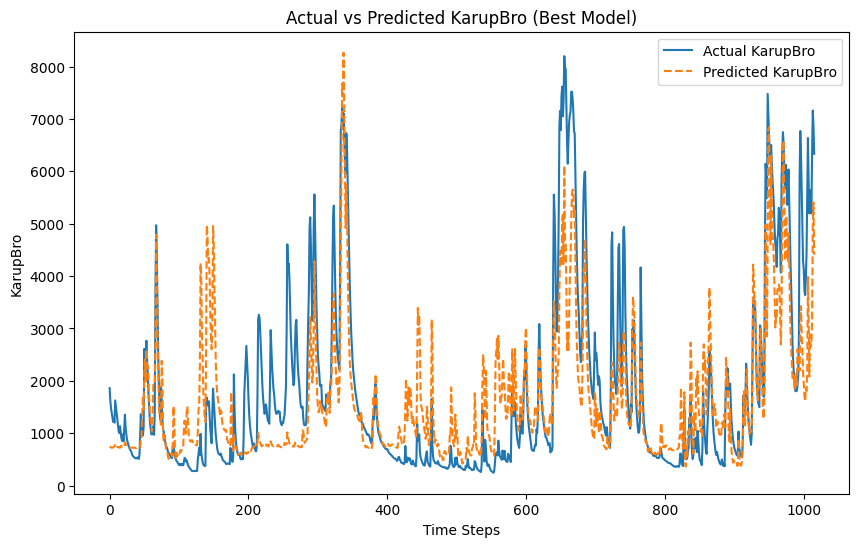

In [30]:
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Define the grid of hyperparameters
hyperparameter_grid = {
    "loss": ["mse"],
    "batch_size": [8],
    "learning_rate": [0.001],
    "lstm_units": [400],
    "layers": [1],
    "time_steps": [30]
}

# Helper functions
def preprocess_data(df, time_steps):
    # Scale features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df[["NedbørByg", "NedbørHessel"]])
    y_scaled = scaler_y.fit_transform(df["KarupBro"].values.reshape(-1, 1))
    
    # Create time-series dataset
    X_series, y_series = [], []
    for i in range(time_steps, len(X_scaled)):
        X_series.append(X_scaled[i - time_steps:i])
        y_series.append(y_scaled[i])
    return np.array(X_series), np.array(y_series), scaler_y

def build_model(time_steps, features, lstm_units, layers, loss, learning_rate):
    model = Sequential()
    for i in range(layers):
        model.add(LSTM(lstm_units, return_sequences=(i < layers - 1), input_shape=(time_steps, features)))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss=loss)
    model.optimizer.lr = learning_rate
    return model

def train_and_evaluate_model(params, X_train, y_train, X_val, y_val, features):
    # Extract parameters
    time_steps = params["time_steps"]
    lstm_units = params["lstm_units"]
    layers = params["layers"]
    loss = params["loss"]
    batch_size = params["batch_size"]
    learning_rate = params["learning_rate"]

    # Build the model
    model = build_model(time_steps, features, lstm_units, layers, loss, learning_rate)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,  # Reduced for quick testing; can increase for full runs
        batch_size=batch_size,
        verbose=0
    )
    # Return the validation loss from the last epoch
    return history.history["val_loss"][-1], model

# Perform grid search with logging
def full_grid_search_with_logging(df):
    best_loss = float("inf")
    best_params = None
    best_model = None

    # Iterate over all combinations of hyperparameters
    keys, values = zip(*hyperparameter_grid.items())
    total_combinations = len(list(itertools.product(*values)))
    combination_count = 1

    for combination in itertools.product(*values):
        params = dict(zip(keys, combination))
        
        # Preprocess data for current time_steps
        X_series, y_series, scaler_y = preprocess_data(df, params["time_steps"])

        # Perform a train-validation-test split
        X_train, X_temp, y_train, y_temp = train_test_split(X_series, y_series, test_size=0.4, shuffle=False)  # 60% train, 40% temp
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)  # 20% val, 20% test
        features = X_series.shape[2]

        # Train and evaluate the model
        val_loss, model = train_and_evaluate_model(params, X_train, y_train, X_val, y_val, features)

        # Log progress and results
        print(f"Combination {combination_count}/{total_combinations}: {params}")
        print(f"Validation Loss: {val_loss}\n")
        combination_count += 1

        # Track the best parameters
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            best_model = model
            best_test_data = (X_test, y_test)

    return best_params, best_loss, best_model, scaler_y, best_test_data

# Grid search with logging
best_params, best_loss, best_model, scaler_y, best_test_data = full_grid_search_with_logging(merged_df)

# Best parameters
print("Best Parameters:", best_params)
print("Best Validation Loss:", best_loss)

# Evaluate and plot predictions using best model
def plot_predictions(best_model, scaler_y, X_test, y_test):
    # Predict on test data
    y_pred = best_model.predict(X_test)
    y_test_inverse = scaler_y.inverse_transform(y_test)
    y_pred_inverse = scaler_y.inverse_transform(y_pred)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inverse, label="Actual KarupBro")
    plt.plot(y_pred_inverse, label="Predicted KarupBro", linestyle="dashed")
    plt.xlabel("Time Steps")
    plt.ylabel("KarupBro")
    plt.title("Actual vs Predicted KarupBro (Best Model)")
    plt.legend()
    plt.show()

# Plot predictions using the true test set
X_test, y_test = best_test_data
plot_predictions(best_model, scaler_y, X_test, y_test)


Timestep 5: Validation Loss = 0.0258
Timestep 10: Validation Loss = 0.0254
Timestep 20: Validation Loss = 0.0272
Timestep 30: Validation Loss = 0.0248
Timestep 50: Validation Loss = 0.0225


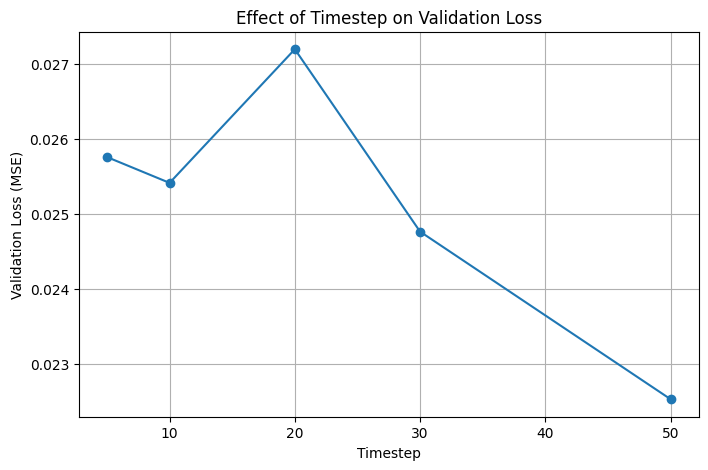

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Define fixed hyperparameters
loss_function = "mse"
batch_size = 8
learning_rate = 0.001
lstm_units = 400
layers = 1

# Define a range of time steps to test
time_steps_list = [5, 10, 20, 30, 50]

# Store results
losses = []

# Helper function to preprocess data
def preprocess_data(df, time_steps):
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(df[["NedbørByg", "NedbørHessel"]])
    y_scaled = scaler_y.fit_transform(df["KarupBro"].values.reshape(-1, 1))
    
    X_series, y_series = [], []
    for i in range(time_steps, len(X_scaled)):
        X_series.append(X_scaled[i - time_steps:i])
        y_series.append(y_scaled[i])
        
    return np.array(X_series), np.array(y_series), scaler_y

# Function to build LSTM model
def build_model(time_steps, features):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=False, input_shape=(time_steps, features)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function)
    return model

# Iterate over different timesteps
for time_steps in time_steps_list:
    # Preprocess data
    X_series, y_series, scaler_y = preprocess_data(merged_df, time_steps)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X_series, y_series, test_size=0.4, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    features = X_series.shape[2]

    # Build and train model
    model = build_model(time_steps, features)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=batch_size, verbose=0)

    # Get validation loss
    val_loss = history.history["val_loss"][-1]
    losses.append(val_loss)

    print(f"Timestep {time_steps}: Validation Loss = {val_loss:.4f}")

# Plot loss as function of timestep
plt.figure(figsize=(8, 5))
plt.plot(time_steps_list, losses, marker="o", linestyle="-")
plt.xlabel("Timestep")
plt.ylabel("Validation Loss (MSE)")
plt.title("Effect of Timestep on Validation Loss")
plt.grid(True)
plt.show()


In [31]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error

# # Best Parameters
# best_params = {'loss': 'mse', 'batch_size': 8, 'learning_rate': 0.001, 'lstm_units': 400, 'layers': 1, 'time_steps': 30}

# # Preprocessing data using the best time_steps
# time_steps = best_params["time_steps"]
# X_series, y_series, scaler_y = preprocess_data(merged_df, time_steps)
# X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, shuffle=False)
# features = X_series.shape[2]

# # Building model with the best parameters
# def build_best_model(best_params, features):
#     model = Sequential()
#     for i in range(best_params["layers"]):
#         model.add(LSTM(best_params["lstm_units"], return_sequences=(i < best_params["layers"] - 1),
#                        input_shape=(best_params["time_steps"], features)))
#         model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(optimizer="adam", loss=best_params["loss"])
#     model.optimizer.lr = best_params["learning_rate"]
#     return model

# best_model = build_best_model(best_params, features)

# # Train the best model
# history = best_model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=best_params["batch_size"],
#     verbose=1
# )

# # Predict on test set
# y_pred = best_model.predict(X_test)
# y_test_inverse = scaler_y.inverse_transform(y_test)
# y_pred_inverse = scaler_y.inverse_transform(y_pred)

# # Evaluate on all data (General MAE)
# general_mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
# print(f"General MAE: {general_mae}")

# # Evaluate on extreme cases
# extreme_threshold = np.percentile(y_test_inverse, 90)  # Top 10% as extremes
# extreme_indices = y_test_inverse.flatten() >= extreme_threshold
# extreme_mae = mean_absolute_error(y_test_inverse[extreme_indices], y_pred_inverse[extreme_indices])
# print(f"Extreme MAE: {extreme_mae}")

# # Plot predictions vs actual values for extremes
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_inverse[extreme_indices], label="Actual KarupBro (Extremes)", marker="o")
# plt.plot(y_pred_inverse[extreme_indices], label="Predicted KarupBro (Extremes)", marker="x")
# plt.xlabel("Extreme Instances")
# plt.ylabel("KarupBro")
# plt.title("Actual vs Predicted KarupBro (Extremes)")
# plt.legend()
# plt.show()

Epoch 1/50
508/508 [==============================] - 15s 28ms/step - loss: 0.0271 - val_loss: 0.0279
Epoch 2/50
508/508 [==============================] - 14s 27ms/step - loss: 0.0260 - val_loss: 0.0243
Epoch 3/50
508/508 [==============================] - 14s 27ms/step - loss: 0.0262 - val_loss: 0.0271
Epoch 4/50
508/508 [==============================] - 14s 27ms/step - loss: 0.0252 - val_loss: 0.0233
Epoch 5/50
508/508 [==============================] - 14s 28ms/step - loss: 0.0250 - val_loss: 0.0238
Epoch 6/50
508/508 [==============================] - 14s 28ms/step - loss: 0.0250 - val_loss: 0.0247
Epoch 7/50
508/508 [==============================] - 14s 28ms/step - loss: 0.0249 - val_loss: 0.0258
Epoch 8/50
508/508 [==============================] - 14s 28ms/step - loss: 0.0245 - val_loss: 0.0207
Epoch 9/50
508/508 [==============================] - 14s 28ms/step - loss: 0.0243 - val_loss: 0.0213
Epoch 10/50
508/508 [==============================] - 15s 29ms/step - loss: 0.023

KeyboardInterrupt: 